<a href="https://colab.research.google.com/github/Rohith-Rongali/IMP/blob/main/IMP_DT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torch.nn.utils.prune as prune

from copy import deepcopy

from tqdm import tqdm
import os

import numpy as np
import matplotlib.pyplot as plt

from types import SimpleNamespace

# Data functions

In [2]:
def generate_points(num=40000,dim=18,type='normal',normal_var=1,radius=1):
    '''
    If type=='normal', then generate points from N(0,normal_var)
    If type=='spherical', then simply divide the points by their norm.'''
    X = torch.randn([num,dim]) #coordinates sampled from N(0,1)

    if type=='spherical':
      norm = torch.norm(X, p=2, dim=1, keepdim=True)
      X_spherical = X / norm
      return X_spherical

    elif type=='normal':
      return X

    else:
      raise ValueError('type should be either normal or spherical')


class TreeNode:
    '''
    This class represents a node in the decision tree.
    Each node has a depth, a maximum depth(of the tree), a feature index, and left and right child nodes.
    Leaf nodes have a value, which is the predicted class.
    '''
    def __init__(self, depth, max_depth, feature_index):
        self.depth = depth
        self.max_depth = max_depth
        self.feature = feature_index
        self.left = None
        self.right = None
        self.value = None  # This will store the predicted class for leaf nodes

    def build_tree(self):
        if self.depth == self.max_depth:
            self.value = float(self.feature % 2)
            return

        # Create left and right child nodes
        self.left = TreeNode(self.depth + 1, self.max_depth, 2*self.feature+1)
        self.right = TreeNode(self.depth + 1, self.max_depth, 2*self.feature+2)

        # Recursively build left and right subtrees
        self.left.build_tree()
        self.right.build_tree()

    def predict(self, x):
        if self.value is not None:
            return self.value

        if x[self.feature] > 0:
            return self.left.predict(x)
        else:
            return self.right.predict(x)


def gen_std_basis_DT(depth, dim_in, type_data, num_points, feat_index_start=0,radius=1):
    '''
    Generate points uniformly random from a hypersphere. And the label is the prediction of the tree with depth = max_depth.
    The node hyperplanes are simply characterised by standard basis vectors(for example, the root node hyperplane is x[0] = 0)

    '''
    Tree = TreeNode(depth = 0,max_depth=depth,feature_index = feat_index_start)
    Tree.build_tree()
    X = generate_points(num=num_points,dim=dim_in,type=type_data,radius=radius)

    Y=[]
    for item in X:
        Y.append(Tree.predict(item))

    Y = torch.tensor(Y)
    return X,Y




def set_npseed(seed):
	np.random.seed(seed)


def set_torchseed(seed):
	torch.manual_seed(seed)
	torch.cuda.manual_seed(seed)
	torch.cuda.manual_seed_all(seed)
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False



# depth = 4
# dim_in = 18
# type_data = 'normal'
# feat_index_start = 0 #the index of the first feature in the tree
# num_points = 40000


#     Tree = TreeNode(depth = 0,max_depth=depth,feature_index = feat_index_start)
#     Tree.build_tree()
#     X = generate_points(num=num_points,dim=dim_in,type=type_data)

#     Y=[]
#     for item in X:
#     Y.append(Tree.predict(item))

#     Y = torch.tensor(Y)

class CustomDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        sample_x = self.x[idx]
        sample_y = self.y[idx]

        if self.transform:
            sample_x, sample_y = self.transform(sample_x, sample_y)

        return sample_x, sample_y

def return_data_elements(DataConfig):
    # returns [data] and data_loader

    x_train,y_train = gen_std_basis_DT(depth = DataConfig.depth, dim_in = DataConfig.dim_in, num_points = DataConfig.num_points,type_data= DataConfig.type_data, radius = DataConfig.radius)
    x_test,y_test = gen_std_basis_DT(depth = DataConfig.depth, dim_in = DataConfig.dim_in, num_points = DataConfig.num_points,type_data= DataConfig.type_data, radius = DataConfig.radius)
    # x_train, x_test, y_train, y_test = train_test_split(
    # X, Y, test_size=0.1, random_state=42, stratify=Y)

    data = [x_train,y_train.long(),x_test,y_test.long()]

    return data

def loaders(data,batch_size=32):
    x_train,y_train,x_test,y_test = data
    train_dataset = CustomDataset(x_train, y_train)
    test_dataset = CustomDataset(x_test, y_test)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_dataloader, test_dataloader

# Models


In [3]:
class DNN(nn.Module):
    def __init__(self, dim_in, dim_out, width, depth):
        super(DNN, self).__init__()
        self.depth = depth
        self.layers = nn.ModuleList([nn.Linear(dim_in if i == 0 else width, width) for i in range(self.depth)])
        self.output_layer = nn.Linear(width, dim_out)
        self.relu = nn.ReLU()

    def forward(self, x):
        for layer in self.layers:
            x = self.relu(layer(x))
        x = self.output_layer(x)
        return x

# Configs

In [4]:

model_config = SimpleNamespace(
    width=256,
    depth=2
)

data_config = SimpleNamespace(
    dim_in=100,
    depth=4,
    type_data='spherical',
    num_points=30000,
    radius=1,
    dim_out=2
)

train_config = SimpleNamespace(
    batch_size=32,
    lr=0.01,
    epochs=100
)


# Training

In [5]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

In [6]:
device

device(type='cuda', index=2)

In [7]:
data= return_data_elements(data_config)
x_train,y_train,x_test,y_test = data

In [8]:
# Create DataLoaders for train and test datasets
batch_size = 32

# Assuming you have a custom Dataset class, you can create instances like this:
train_dataset = CustomDataset(x_train, y_train)
test_dataset = CustomDataset(x_test, y_test)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [23]:
model = DNN(dim_in=data_config.dim_in, dim_out=data_config.dim_out, width=model_config.width, depth=model_config.depth)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=train_config.lr, momentum=0.9)

In [20]:
def train(model,loss_fn,optimizer,train_dataloader,
          data,num_epochs=train_config.epochs,log_epochs=10,log_acc=10,thresh=1e-5,print_std=True):
  [x_train,y_train,x_test,y_test]=data
  model.to(device)
  Train_losses=[]
  acc_dict = {'train':[],'test':[]}
  for epoch in range(num_epochs):
      model.train()
      for x_batch, y_batch in train_dataloader:
          x_batch = x_batch.to(device)
          y_batch = y_batch.to(device)
          pred = model(x_batch)
          loss = loss_fn(pred, y_batch)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()


      if epoch % log_epochs == 0:
          loss_full = loss_fn(model(x_train.to(device)),y_train.to(device))
          Train_losses.append(loss_full.item())
          print(f'Epoch {epoch} Loss {loss_full.item():.4f}')
      if log_acc!=0:
        if epoch % log_acc == 0:
          train_pred = model(x_train.to(device))
          pred = torch.argmax(model(x_train.to(device)),dim=1)
          zero_mask = (pred-y_train.to(device) == 0.0)
          train_acc = zero_mask.sum().item()/len(y_train)
          acc_dict['train'].append(train_acc)

          test_pred = model(x_test.to(device))[:,0]
          pred = torch.argmax(model(x_test.to(device)),dim=1)
          zero_mask = (pred-y_test.to(device) == 0.0)
          test_acc = zero_mask.sum().item()/len(y_test)
          acc_dict['test'].append(test_acc)

          if print_std:
            print(f'Epoch {epoch} train_acc {train_acc} test_acc {test_acc}')
      if loss_full.item() < thresh:
          print(f'Early stopping at epoch {epoch} because loss is below 0.01')
          break

  return Train_losses,acc_dict

In [21]:
# save model in a new folder
model_path = 'models'
os.makedirs(model_path, exist_ok=True)
torch.save(model.state_dict(), os.path.join(model_path, 'model_init.pt'))

In [24]:
losses, acc_dict = train(model,loss_fn,optimizer,train_dataloader,data)

Epoch 0 Loss 0.6731
Epoch 0 train_acc 0.6071 test_acc 0.5918666666666667
Epoch 10 Loss 0.5241
Epoch 10 train_acc 0.7403666666666666 test_acc 0.6646666666666666
Epoch 20 Loss 0.3820
Epoch 20 train_acc 0.8295333333333333 test_acc 0.6703333333333333
Epoch 30 Loss 0.2249
Epoch 30 train_acc 0.9162 test_acc 0.6659666666666667
Epoch 40 Loss 0.1301
Epoch 40 train_acc 0.9490666666666666 test_acc 0.6588333333333334
Epoch 50 Loss 0.0963
Epoch 50 train_acc 0.9633666666666667 test_acc 0.6532333333333333
Epoch 60 Loss 0.0453
Epoch 60 train_acc 0.9841333333333333 test_acc 0.6562
Epoch 70 Loss 0.0428
Epoch 70 train_acc 0.9841333333333333 test_acc 0.6533333333333333
Epoch 80 Loss 0.0005
Epoch 80 train_acc 1.0 test_acc 0.6637
Epoch 90 Loss 0.0003
Epoch 90 train_acc 1.0 test_acc 0.6633


In [25]:
# save model in a new folder
torch.save(model.state_dict(), os.path.join(model_path, 'model0.pt'))

## Large learning rate schedule

In [14]:
model = DNN(dim_in=data_config.dim_in, dim_out=data_config.dim_out, width=model_config.width, depth=model_config.depth)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
# 


## Pruning

So far everything is the same. I set the pruning rate as $p ^ {1/n}$, this still works to some extent... Not sure how? I think we should still figure out some other schemes, maybe we can threshold the weights instead of removing a certain amount of smaller magnitude weights.... could try constant pruning fraction as well....

In [1]:
# To compare pruning rate heuristics
for i in [0.1,0.2,0.3,0.4]:
    x=1
    print(' ')
    print(f'pruning rate={i}')
    for j in range(1,21):
        print(f'Pruning {j} {x*(1-i**(1/j))} {(1-i)**j}')


 
pruning rate=0.1
Pruning 1 0.9 0.9
Pruning 2 0.683772233983162 0.81
Pruning 3 0.535841116638722 0.7290000000000001
Pruning 4 0.4376586748096509 0.6561
Pruning 5 0.36904265551980675 0.5904900000000001
Pruning 6 0.31870793094203864 0.531441
Pruning 7 0.28031432699884795 0.4782969000000001
Pruning 8 0.2501057906675441 0.4304672100000001
Pruning 9 0.2257363173188729 0.3874204890000001
Pruning 10 0.2056717652757185 0.3486784401000001
Pruning 11 0.18886916921031294 0.31381059609000006
Pruning 12 0.1745958147319816 0.2824295364810001
Pruning 13 0.16232235993170807 0.2541865828329001
Pruning 14 0.15165710175592795 0.2287679245496101
Pruning 15 0.14230410140910588 0.20589113209464907
Pruning 16 0.13403567663993465 0.18530201888518416
Pruning 17 0.12667383761715667 0.16677181699666577
Pruning 18 0.12007745643089296 0.15009463529699918
Pruning 19 0.11413320958991735 0.13508517176729928
Pruning 20 0.10874906186625444 0.12157665459056935
 
pruning rate=0.2
Pruning 1 0.8 0.8
Pruning 2 0.5527864045

In [13]:
model = DNN(dim_in=data_config.dim_in, dim_out=data_config.dim_out, width=model_config.width, depth=model_config.depth)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=train_config.lr)

In [14]:
INITIAL_WEIGHTS = deepcopy(model.state_dict())
prune_epochs=6
p = 0.2
losses = {}
acc_dict = {}
for n in tqdm(range(1, prune_epochs + 1), total=prune_epochs, leave=False):

  losses[n], acc_dict[n] = train(model,loss_fn,optimizer,train_dataloader,data)
  
  # Save the model with different model name using value of n
  torch.save(model.state_dict(), os.path.join(model_path, 'model'+f'{n}'+'.pt'))

  pruning_rate = p ** (1 / n)

  # Prune the model
  prune.l1_unstructured(model.layers[0], name="weight", amount=pruning_rate)
  prune.l1_unstructured(model.layers[1], name="weight", amount=pruning_rate)
  prune.l1_unstructured(model.output_layer, name="weight", amount=pruning_rate/2)

  # Reset weights
  reseted_weights = deepcopy(model.state_dict())
  for param in reseted_weights.keys():
      if param.split(".")[-1].replace("_orig", "") in ("bias", "weight"):
          reseted_weights[param] = deepcopy(INITIAL_WEIGHTS[param.replace("_orig", "")])
  if n< prune_epochs-1:
    model.load_state_dict(reseted_weights)
  


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 0 Loss 0.6048
Epoch 0 train_acc 0.6732666666666667 test_acc 0.6371666666666667
Epoch 10 Loss 0.1312
Epoch 10 train_acc 0.9514333333333334 test_acc 0.6786666666666666
Epoch 20 Loss 0.0665
Epoch 20 train_acc 0.9756666666666667 test_acc 0.6755333333333333
Epoch 30 Loss 0.0575
Epoch 30 train_acc 0.9806 test_acc 0.6731666666666667
Epoch 40 Loss 0.0411
Epoch 40 train_acc 0.9864333333333334 test_acc 0.676
Epoch 50 Loss 0.0491
Epoch 50 train_acc 0.9845333333333334 test_acc 0.6781666666666667
Epoch 60 Loss 0.0433
Epoch 60 train_acc 0.9877666666666667 test_acc 0.6743333333333333
Epoch 70 Loss 0.0395
Epoch 70 train_acc 0.9889333333333333 test_acc 0.6727666666666666
Epoch 80 Loss 0.0399
Epoch 80 train_acc 0.9897 test_acc 0.6785
Epoch 90 Loss 0.0317
Epoch 90 train_acc 0.9920666666666667 test_acc 0.6789


 17%|█▋        | 1/6 [01:45<08:47, 105.59s/it]

Epoch 0 Loss 0.6334
Epoch 0 train_acc 0.6309 test_acc 0.6168
Epoch 10 Loss 0.1462
Epoch 10 train_acc 0.9446 test_acc 0.7248333333333333
Epoch 20 Loss 0.0625
Epoch 20 train_acc 0.9775666666666667 test_acc 0.7233666666666667
Epoch 30 Loss 0.0500
Epoch 30 train_acc 0.9832333333333333 test_acc 0.7227333333333333
Epoch 40 Loss 0.0594
Epoch 40 train_acc 0.9796666666666667 test_acc 0.7171333333333333
Epoch 50 Loss 0.0348
Epoch 50 train_acc 0.9888 test_acc 0.7212
Epoch 60 Loss 0.0368
Epoch 60 train_acc 0.9889333333333333 test_acc 0.7248666666666667
Epoch 70 Loss 0.0272
Epoch 70 train_acc 0.9921333333333333 test_acc 0.7292666666666666
Epoch 80 Loss 0.0319
Epoch 80 train_acc 0.9915666666666667 test_acc 0.7283
Epoch 90 Loss 0.0406
Epoch 90 train_acc 0.9902 test_acc 0.7276


 33%|███▎      | 2/6 [03:43<07:31, 112.93s/it]

Epoch 0 Loss 0.5888
Epoch 0 train_acc 0.6880333333333334 test_acc 0.6579666666666667
Epoch 10 Loss 0.1294
Epoch 10 train_acc 0.9512666666666667 test_acc 0.8279
Epoch 20 Loss 0.0659
Epoch 20 train_acc 0.9763666666666667 test_acc 0.8229666666666666
Epoch 30 Loss 0.0456
Epoch 30 train_acc 0.9836333333333334 test_acc 0.8231333333333334
Epoch 40 Loss 0.0812
Epoch 40 train_acc 0.9742666666666666 test_acc 0.8178333333333333
Epoch 50 Loss 0.0482
Epoch 50 train_acc 0.9848 test_acc 0.8219666666666666
Epoch 60 Loss 0.0282
Epoch 60 train_acc 0.9902333333333333 test_acc 0.8240666666666666
Epoch 70 Loss 0.0219
Epoch 70 train_acc 0.9933666666666666 test_acc 0.8284333333333334
Epoch 80 Loss 0.0237
Epoch 80 train_acc 0.9927666666666667 test_acc 0.8245333333333333
Epoch 90 Loss 0.0370
Epoch 90 train_acc 0.9884 test_acc 0.8243


 50%|█████     | 3/6 [05:45<05:50, 116.84s/it]

Epoch 0 Loss 0.5972
Epoch 0 train_acc 0.6758 test_acc 0.6582333333333333
Epoch 10 Loss 0.1894
Epoch 10 train_acc 0.9226666666666666 test_acc 0.8830666666666667
Epoch 20 Loss 0.0978
Epoch 20 train_acc 0.9617 test_acc 0.9099333333333334
Epoch 30 Loss 0.0774
Epoch 30 train_acc 0.9690333333333333 test_acc 0.9133333333333333
Epoch 40 Loss 0.0540
Epoch 40 train_acc 0.9797666666666667 test_acc 0.922
Epoch 50 Loss 0.0643
Epoch 50 train_acc 0.9765 test_acc 0.9146666666666666
Epoch 60 Loss 0.0470
Epoch 60 train_acc 0.9817666666666667 test_acc 0.9182666666666667
Epoch 70 Loss 0.0328
Epoch 70 train_acc 0.9874 test_acc 0.9213666666666667
Epoch 80 Loss 0.0405
Epoch 80 train_acc 0.9858333333333333 test_acc 0.9202
Epoch 90 Loss 0.0215
Epoch 90 train_acc 0.9926333333333334 test_acc 0.9216


 67%|██████▋   | 4/6 [07:44<03:55, 117.89s/it]

Epoch 0 Loss 0.6090
Epoch 0 train_acc 0.6644 test_acc 0.6515333333333333
Epoch 10 Loss 0.2020
Epoch 10 train_acc 0.9184 test_acc 0.9068
Epoch 20 Loss 0.1307
Epoch 20 train_acc 0.95 test_acc 0.9341333333333334
Epoch 30 Loss 0.1088
Epoch 30 train_acc 0.9588666666666666 test_acc 0.9421666666666667
Epoch 40 Loss 0.1231
Epoch 40 train_acc 0.9527333333333333 test_acc 0.9370333333333334
Epoch 50 Loss 0.1012
Epoch 50 train_acc 0.9580666666666666 test_acc 0.9406666666666667
Epoch 60 Loss 0.0855
Epoch 60 train_acc 0.9669333333333333 test_acc 0.9489
Epoch 70 Loss 0.0784
Epoch 70 train_acc 0.9692 test_acc 0.9502
Epoch 80 Loss 0.0878
Epoch 80 train_acc 0.9638 test_acc 0.9465666666666667
Epoch 90 Loss 0.0770
Epoch 90 train_acc 0.9709666666666666 test_acc 0.9519666666666666


 83%|████████▎ | 5/6 [09:43<01:58, 118.34s/it]

Epoch 0 Loss 0.0663
Epoch 0 train_acc 0.9746666666666667 test_acc 0.9596333333333333
Epoch 10 Loss 0.0641
Epoch 10 train_acc 0.9742 test_acc 0.9598333333333333
Epoch 20 Loss 0.0625
Epoch 20 train_acc 0.9764333333333334 test_acc 0.9649333333333333
Epoch 30 Loss 0.0543
Epoch 30 train_acc 0.9799 test_acc 0.9652
Epoch 40 Loss 0.0460
Epoch 40 train_acc 0.9837333333333333 test_acc 0.9707333333333333
Epoch 50 Loss 0.0536
Epoch 50 train_acc 0.9794 test_acc 0.9649
Epoch 60 Loss 0.0425
Epoch 60 train_acc 0.9841 test_acc 0.9717333333333333
Epoch 70 Loss 0.0472
Epoch 70 train_acc 0.9826 test_acc 0.9686333333333333
Epoch 80 Loss 0.0514
Epoch 80 train_acc 0.9797 test_acc 0.9673666666666667
Epoch 90 Loss 0.0472
Epoch 90 train_acc 0.9822 test_acc 0.9673666666666667


In [15]:
prune_epochs=6
p = 0.2
losses = {}
acc_dict = {}
for n in tqdm(range(prune_epochs+1, 2*prune_epochs + 1), total=prune_epochs, leave=False):

  losses[n], acc_dict[n] = train(model,loss_fn,optimizer,train_dataloader,data)
  
  # Save the model with different model name using value of n
  torch.save(model.state_dict(), os.path.join(model_path, 'model'+f'{n}'+'.pt'))

  pruning_rate = p ** (1 / n)

  # Prune the model
  prune.l1_unstructured(model.layers[0], name="weight", amount=pruning_rate)
  prune.l1_unstructured(model.layers[1], name="weight", amount=pruning_rate)
  prune.l1_unstructured(model.output_layer, name="weight", amount=pruning_rate/2)

  # Reset weights
  reseted_weights = deepcopy(model.state_dict())
  for param in reseted_weights.keys():
      if param.split(".")[-1].replace("_orig", "") in ("bias", "weight"):
          reseted_weights[param] = deepcopy(INITIAL_WEIGHTS[param.replace("_orig", "")])
  if n< prune_epochs-1:
    model.load_state_dict(reseted_weights)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 0 Loss 0.1021
Epoch 0 train_acc 0.9692 test_acc 0.9665
Epoch 10 Loss 0.0778
Epoch 10 train_acc 0.9743333333333334 test_acc 0.9725
Epoch 20 Loss 0.0768
Epoch 20 train_acc 0.9762666666666666 test_acc 0.9761333333333333
Epoch 30 Loss 0.0692
Epoch 30 train_acc 0.9752666666666666 test_acc 0.9733333333333334
Epoch 40 Loss 0.0538
Epoch 40 train_acc 0.9837333333333333 test_acc 0.9823333333333333
Epoch 50 Loss 0.0504
Epoch 50 train_acc 0.9851666666666666 test_acc 0.9835666666666667
Epoch 60 Loss 0.0512
Epoch 60 train_acc 0.9844 test_acc 0.9827666666666667
Epoch 70 Loss 0.0514
Epoch 70 train_acc 0.9848333333333333 test_acc 0.9821
Epoch 80 Loss 0.0509
Epoch 80 train_acc 0.9845333333333334 test_acc 0.9818333333333333
Epoch 90 Loss 0.0490
Epoch 90 train_acc 0.9843666666666666 test_acc 0.9829


 17%|█▋        | 1/6 [02:02<10:12, 122.47s/it]

Epoch 0 Loss 0.5124
Epoch 0 train_acc 0.7391333333333333 test_acc 0.7406666666666667
Epoch 10 Loss 0.5043
Epoch 10 train_acc 0.7152 test_acc 0.7160666666666666
Epoch 20 Loss 0.4995
Epoch 20 train_acc 0.7502666666666666 test_acc 0.7459666666666667
Epoch 30 Loss 0.4982
Epoch 30 train_acc 0.7382 test_acc 0.7323666666666667
Epoch 40 Loss 0.4976
Epoch 40 train_acc 0.7624333333333333 test_acc 0.7577
Epoch 50 Loss 0.4992
Epoch 50 train_acc 0.7628333333333334 test_acc 0.7576
Epoch 60 Loss 0.4975
Epoch 60 train_acc 0.7513666666666666 test_acc 0.7467333333333334
Epoch 70 Loss 0.4978
Epoch 70 train_acc 0.7384 test_acc 0.7316666666666667
Epoch 80 Loss 0.4953
Epoch 80 train_acc 0.7518333333333334 test_acc 0.7463
Epoch 90 Loss 0.4979
Epoch 90 train_acc 0.7644333333333333 test_acc 0.7600666666666667


 33%|███▎      | 2/6 [04:02<08:04, 121.14s/it]

Epoch 0 Loss 0.6957
Epoch 0 train_acc 0.5001333333333333 test_acc 0.4986
Epoch 10 Loss 0.6859
Epoch 10 train_acc 0.5630333333333334 test_acc 0.5574666666666667
Epoch 20 Loss 0.6856
Epoch 20 train_acc 0.5622666666666667 test_acc 0.5576333333333333
Epoch 30 Loss 0.6858
Epoch 30 train_acc 0.5629 test_acc 0.5576666666666666
Epoch 40 Loss 0.6852
Epoch 40 train_acc 0.5629 test_acc 0.5576666666666666
Epoch 50 Loss 0.6857
Epoch 50 train_acc 0.5614 test_acc 0.5548
Epoch 60 Loss 0.6877
Epoch 60 train_acc 0.5591666666666667 test_acc 0.5547
Epoch 70 Loss 0.6858
Epoch 70 train_acc 0.5618 test_acc 0.5552666666666667
Epoch 80 Loss 0.6863
Epoch 80 train_acc 0.5627333333333333 test_acc 0.5566
Epoch 90 Loss 0.6856
Epoch 90 train_acc 0.5622 test_acc 0.5576


 50%|█████     | 3/6 [06:03<06:03, 121.03s/it]

Epoch 0 Loss 0.6931
Epoch 0 train_acc 0.5001333333333333 test_acc 0.4986
Epoch 10 Loss 0.6939
Epoch 10 train_acc 0.5001333333333333 test_acc 0.4986
Epoch 20 Loss 0.6932
Epoch 20 train_acc 0.4998666666666667 test_acc 0.5014
Epoch 30 Loss 0.6938
Epoch 30 train_acc 0.4998666666666667 test_acc 0.5014
Epoch 40 Loss 0.6949
Epoch 40 train_acc 0.5001333333333333 test_acc 0.4986
Epoch 50 Loss 0.6936
Epoch 50 train_acc 0.5001333333333333 test_acc 0.4986
Epoch 60 Loss 0.6934
Epoch 60 train_acc 0.5001333333333333 test_acc 0.4986
Epoch 70 Loss 0.6932
Epoch 70 train_acc 0.5001333333333333 test_acc 0.4986
Epoch 80 Loss 0.6932
Epoch 80 train_acc 0.4998666666666667 test_acc 0.5014
Epoch 90 Loss 0.6934
Epoch 90 train_acc 0.5001333333333333 test_acc 0.4986


 67%|██████▋   | 4/6 [08:03<04:01, 120.56s/it]

Epoch 0 Loss 0.7008
Epoch 0 train_acc 0.4998666666666667 test_acc 0.5014
Epoch 10 Loss 0.6937
Epoch 10 train_acc 0.5001333333333333 test_acc 0.4986
Epoch 20 Loss 0.6938
Epoch 20 train_acc 0.4998666666666667 test_acc 0.5014
Epoch 30 Loss 0.6947
Epoch 30 train_acc 0.4998666666666667 test_acc 0.5014
Epoch 40 Loss 0.6932
Epoch 40 train_acc 0.4998666666666667 test_acc 0.5014
Epoch 50 Loss 0.6939
Epoch 50 train_acc 0.5001333333333333 test_acc 0.4986
Epoch 60 Loss 0.6935
Epoch 60 train_acc 0.4998666666666667 test_acc 0.5014
Epoch 70 Loss 0.6942
Epoch 70 train_acc 0.5001333333333333 test_acc 0.4986
Epoch 80 Loss 0.6931
Epoch 80 train_acc 0.4998666666666667 test_acc 0.5014
Epoch 90 Loss 0.6932
Epoch 90 train_acc 0.5001333333333333 test_acc 0.4986


 83%|████████▎ | 5/6 [10:02<02:00, 120.04s/it]

Epoch 0 Loss 0.6933
Epoch 0 train_acc 0.5001333333333333 test_acc 0.4986
Epoch 10 Loss 0.6932
Epoch 10 train_acc 0.5001333333333333 test_acc 0.4986
Epoch 20 Loss 0.6944
Epoch 20 train_acc 0.4998666666666667 test_acc 0.5014
Epoch 30 Loss 0.6933
Epoch 30 train_acc 0.4998666666666667 test_acc 0.5014
Epoch 40 Loss 0.6932
Epoch 40 train_acc 0.4998666666666667 test_acc 0.5014
Epoch 50 Loss 0.6937
Epoch 50 train_acc 0.4998666666666667 test_acc 0.5014
Epoch 60 Loss 0.6933
Epoch 60 train_acc 0.5001333333333333 test_acc 0.4986
Epoch 70 Loss 0.6939
Epoch 70 train_acc 0.5001333333333333 test_acc 0.4986
Epoch 80 Loss 0.6938
Epoch 80 train_acc 0.5001333333333333 test_acc 0.4986
Epoch 90 Loss 0.6935
Epoch 90 train_acc 0.5001333333333333 test_acc 0.4986


### Probing

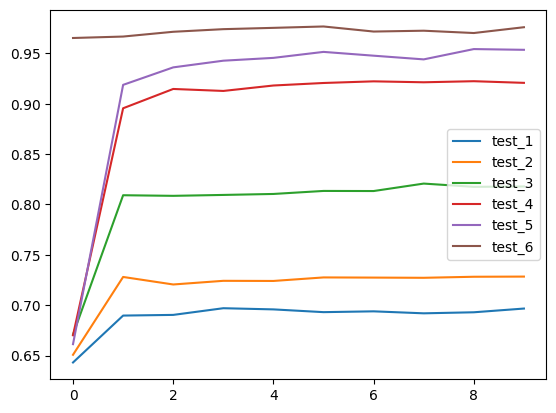

In [16]:
#plot acc_dict(test)
plt.figure()
for key in acc_dict.keys():
#   plt.plot(acc_dict[key]['train'],label=f'train_{key}')
  plt.plot(acc_dict[key]['test'],label=f'test_{key}')
plt.legend()

Text(0, 0.5, 'Final accuracy')

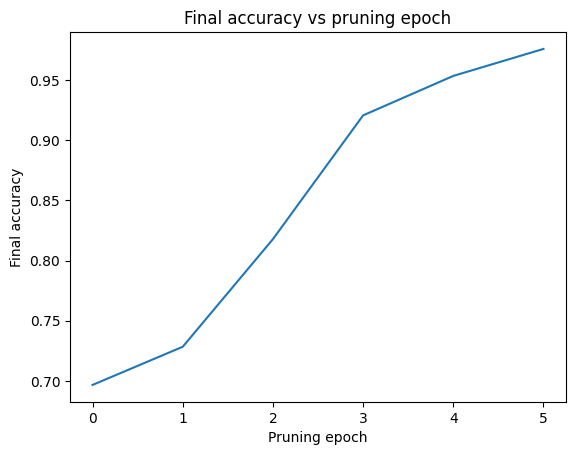

In [17]:
final_acc_list = [acc_dict[key]['test'][-1] for key in acc_dict.keys()]
plt.figure()
plt.plot(final_acc_list)
plt.title('Final accuracy vs pruning epoch')
plt.xlabel('Pruning epoch')
plt.ylabel('Final accuracy')

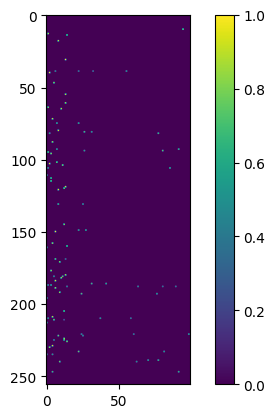

In [18]:
#normalise weights1 row-wise
wt_mat = model.layers[0].weight.data.detach().cpu()
w1_normed=F.normalize(wt_mat,p=2,dim=1)
#visualise w1_normed as heat-map just in absolute values
plt.imshow(w1_normed.abs().numpy())
plt.colorbar()
plt.show()

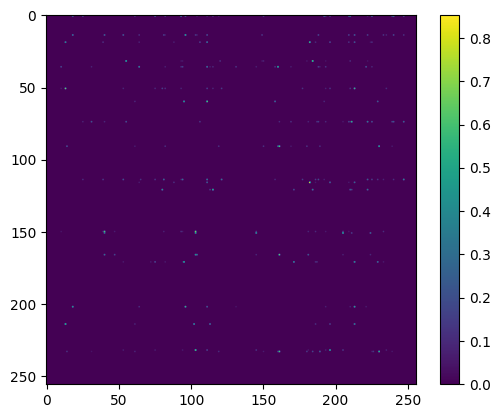

In [19]:
#normalise weights1 row-wise
wt_mat = model.layers[1].weight.data.detach().cpu()
w1_normed=F.normalize(wt_mat,p=2,dim=1)
#visualise w1_normed as heat-map just in absolute values
plt.imshow(w1_normed.abs().numpy())
plt.colorbar()
plt.show()

## One-shot magnitude Pruning

In [17]:
prune_epochs=6
p = 0.2
lossesr = {}
acc_dictr = {}
for n in tqdm(range(1, prune_epochs + 1), total=prune_epochs, leave=False):

  pruning_rate = p ** (1 / n)

  modelr = DNN(dim_in=data_config.dim_in, dim_out=data_config.dim_out, width=model_config.width, depth=model_config.depth)
  loss_fn = nn.CrossEntropyLoss()
  optimizerr = torch.optim.Adam(modelr.parameters(), lr=train_config.lr)
  # Prune the model
  prune.l1_unstructured(modelr.layers[0], name="weight", amount=pruning_rate)
  prune.l1_unstructured(modelr.layers[1], name="weight", amount=pruning_rate)
  prune.l1_unstructured(modelr.output_layer, name="weight", amount=pruning_rate/2)

  lossesr[n], acc_dictr[n] = train(modelr,loss_fn,optimizerr,train_dataloader,data)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 0 Loss 0.6075
Epoch 0 train_acc 0.6732333333333334 test_acc 0.6420333333333333
Epoch 10 Loss 0.1464
Epoch 10 train_acc 0.9438333333333333 test_acc 0.7055666666666667
Epoch 20 Loss 0.0739
Epoch 20 train_acc 0.9727333333333333 test_acc 0.7009666666666666
Epoch 30 Loss 0.0605
Epoch 30 train_acc 0.9787666666666667 test_acc 0.7049
Epoch 40 Loss 0.0448
Epoch 40 train_acc 0.9845666666666667 test_acc 0.7045333333333333
Epoch 50 Loss 0.0545
Epoch 50 train_acc 0.9827333333333333 test_acc 0.7065
Epoch 60 Loss 0.0372
Epoch 60 train_acc 0.9868666666666667 test_acc 0.7101666666666666
Epoch 70 Loss 0.0477
Epoch 70 train_acc 0.9866333333333334 test_acc 0.7076666666666667
Epoch 80 Loss 0.0444
Epoch 80 train_acc 0.9882666666666666 test_acc 0.7096
Epoch 90 Loss 0.0389
Epoch 90 train_acc 0.9886 test_acc 0.7136333333333333


 17%|█▋        | 1/6 [04:12<21:02, 252.53s/it]

Epoch 0 Loss 0.6140
Epoch 0 train_acc 0.6654666666666667 test_acc 0.6423
Epoch 10 Loss 0.1618
Epoch 10 train_acc 0.9379333333333333 test_acc 0.7642666666666666
Epoch 20 Loss 0.0826
Epoch 20 train_acc 0.9693 test_acc 0.7568666666666667
Epoch 30 Loss 0.0554
Epoch 30 train_acc 0.9800333333333333 test_acc 0.7581666666666667
Epoch 40 Loss 0.0463
Epoch 40 train_acc 0.9837333333333333 test_acc 0.7631333333333333
Epoch 50 Loss 0.0371
Epoch 50 train_acc 0.9867 test_acc 0.7633666666666666
Epoch 60 Loss 0.0338
Epoch 60 train_acc 0.9883333333333333 test_acc 0.7678
Epoch 70 Loss 0.0265
Epoch 70 train_acc 0.9912 test_acc 0.7640666666666667
Epoch 80 Loss 0.0322
Epoch 80 train_acc 0.9897 test_acc 0.7631666666666667
Epoch 90 Loss 0.0261
Epoch 90 train_acc 0.9919666666666667 test_acc 0.7623333333333333


 33%|███▎      | 2/6 [07:59<15:50, 237.64s/it]

Epoch 0 Loss 0.5848
Epoch 0 train_acc 0.6931 test_acc 0.6760666666666667
Epoch 10 Loss 0.1684
Epoch 10 train_acc 0.9354333333333333 test_acc 0.8258
Epoch 20 Loss 0.0781
Epoch 20 train_acc 0.9701333333333333 test_acc 0.8257333333333333
Epoch 30 Loss 0.0567
Epoch 30 train_acc 0.9794 test_acc 0.8249
Epoch 40 Loss 0.0496
Epoch 40 train_acc 0.9837 test_acc 0.8266666666666667
Epoch 50 Loss 0.0459
Epoch 50 train_acc 0.9843333333333333 test_acc 0.8308333333333333
Epoch 60 Loss 0.0287
Epoch 60 train_acc 0.9896 test_acc 0.8340666666666666
Epoch 70 Loss 0.0554
Epoch 70 train_acc 0.9844666666666667 test_acc 0.8275666666666667
Epoch 80 Loss 0.0264
Epoch 80 train_acc 0.9916333333333334 test_acc 0.8337
Epoch 90 Loss 0.0223
Epoch 90 train_acc 0.9923666666666666 test_acc 0.8331333333333333


 50%|█████     | 3/6 [12:07<12:06, 242.07s/it]

Epoch 0 Loss 0.5830
Epoch 0 train_acc 0.6911 test_acc 0.6807
Epoch 10 Loss 0.1359
Epoch 10 train_acc 0.9478 test_acc 0.8931333333333333
Epoch 20 Loss 0.0826
Epoch 20 train_acc 0.9708333333333333 test_acc 0.9001
Epoch 30 Loss 0.0504
Epoch 30 train_acc 0.9817 test_acc 0.9013
Epoch 40 Loss 0.0457
Epoch 40 train_acc 0.9840666666666666 test_acc 0.9026
Epoch 50 Loss 0.0287
Epoch 50 train_acc 0.9906 test_acc 0.9045666666666666
Epoch 60 Loss 0.0350
Epoch 60 train_acc 0.9882 test_acc 0.9023
Epoch 70 Loss 0.0172
Epoch 70 train_acc 0.9942 test_acc 0.9044
Epoch 80 Loss 0.0222
Epoch 80 train_acc 0.9928333333333333 test_acc 0.9029
Epoch 90 Loss 0.0171
Epoch 90 train_acc 0.9947333333333334 test_acc 0.9060666666666667


 67%|██████▋   | 4/6 [15:53<07:51, 235.94s/it]

Epoch 0 Loss 0.5894
Epoch 0 train_acc 0.6860333333333334 test_acc 0.6721
Epoch 10 Loss 0.1819
Epoch 10 train_acc 0.9271666666666667 test_acc 0.8794333333333333
Epoch 20 Loss 0.0992
Epoch 20 train_acc 0.9635 test_acc 0.9040333333333334
Epoch 30 Loss 0.0616
Epoch 30 train_acc 0.9789666666666667 test_acc 0.9167
Epoch 40 Loss 0.0500
Epoch 40 train_acc 0.9840666666666666 test_acc 0.9200666666666667
Epoch 50 Loss 0.0383
Epoch 50 train_acc 0.9872666666666666 test_acc 0.9277666666666666
Epoch 60 Loss 0.0402
Epoch 60 train_acc 0.9878333333333333 test_acc 0.9312333333333334
Epoch 70 Loss 0.0381
Epoch 70 train_acc 0.9890666666666666 test_acc 0.9336333333333333
Epoch 80 Loss 0.0390
Epoch 80 train_acc 0.9881666666666666 test_acc 0.9320666666666667
Epoch 90 Loss 0.0227
Epoch 90 train_acc 0.9933 test_acc 0.9404


 83%|████████▎ | 5/6 [19:58<03:59, 239.20s/it]

Epoch 0 Loss 0.5815
Epoch 0 train_acc 0.6918 test_acc 0.6860666666666667
Epoch 10 Loss 0.1698
Epoch 10 train_acc 0.9322333333333334 test_acc 0.905
Epoch 20 Loss 0.1115
Epoch 20 train_acc 0.9565 test_acc 0.924
Epoch 30 Loss 0.0609
Epoch 30 train_acc 0.9790666666666666 test_acc 0.9415333333333333
Epoch 40 Loss 0.0525
Epoch 40 train_acc 0.9824666666666667 test_acc 0.9444666666666667
Epoch 50 Loss 0.0511
Epoch 50 train_acc 0.9821 test_acc 0.9394333333333333
Epoch 60 Loss 0.0290
Epoch 60 train_acc 0.9900666666666667 test_acc 0.9450666666666667
Epoch 70 Loss 0.0369
Epoch 70 train_acc 0.9877 test_acc 0.9386333333333333
Epoch 80 Loss 0.0285
Epoch 80 train_acc 0.9898666666666667 test_acc 0.9425
Epoch 90 Loss 0.0377
Epoch 90 train_acc 0.9884 test_acc 0.9403666666666667


## One-shot Random Pruning

In [22]:
prune_epochs=6
p = 0.2
lossesrp = {}
acc_dictrp = {}
for n in tqdm(range(1, prune_epochs + 1), total=prune_epochs, leave=False):

  pruning_rate = p ** (1 / n)

  modelrp = DNN(dim_in=data_config.dim_in, dim_out=data_config.dim_out, width=model_config.width, depth=model_config.depth)
  loss_fn = nn.CrossEntropyLoss()
  optimizerrp = torch.optim.Adam(modelrp.parameters(), lr=train_config.lr)
  # Prune the model
  prune.random_unstructured(modelrp.layers[0], name="weight", amount=pruning_rate)
  prune.random_unstructured(modelrp.layers[1], name="weight", amount=pruning_rate)
  prune.random_unstructured(modelrp.output_layer, name="weight", amount=pruning_rate/2)

  lossesrp[n], acc_dictrp[n] = train(modelrp,loss_fn,optimizerrp,train_dataloader,data)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 0 Loss 0.6045
Epoch 0 train_acc 0.6701 test_acc 0.6474333333333333
Epoch 10 Loss 0.1359
Epoch 10 train_acc 0.9481666666666667 test_acc 0.6964666666666667
Epoch 20 Loss 0.0631
Epoch 20 train_acc 0.9773333333333334 test_acc 0.6893
Epoch 30 Loss 0.0685
Epoch 30 train_acc 0.9771666666666666 test_acc 0.6886333333333333
Epoch 40 Loss 0.0526
Epoch 40 train_acc 0.9825666666666667 test_acc 0.6882666666666667
Epoch 50 Loss 0.0387
Epoch 50 train_acc 0.9880333333333333 test_acc 0.6971333333333334
Epoch 60 Loss 0.0408
Epoch 60 train_acc 0.9881666666666666 test_acc 0.6941666666666667
Epoch 70 Loss 0.0462
Epoch 70 train_acc 0.9861666666666666 test_acc 0.6888333333333333
Epoch 80 Loss 0.0554
Epoch 80 train_acc 0.9852333333333333 test_acc 0.6967
Epoch 90 Loss 0.0410
Epoch 90 train_acc 0.9892333333333333 test_acc 0.6945


 17%|█▋        | 1/6 [04:39<23:16, 279.26s/it]

Epoch 0 Loss 0.6015
Epoch 0 train_acc 0.6708 test_acc 0.6541666666666667
Epoch 10 Loss 0.1587
Epoch 10 train_acc 0.9375333333333333 test_acc 0.7828333333333334
Epoch 20 Loss 0.0715
Epoch 20 train_acc 0.9732 test_acc 0.7859333333333334
Epoch 30 Loss 0.0668
Epoch 30 train_acc 0.9751 test_acc 0.7817666666666667
Epoch 40 Loss 0.0423
Epoch 40 train_acc 0.9847 test_acc 0.7876666666666666
Epoch 50 Loss 0.0414
Epoch 50 train_acc 0.9865333333333334 test_acc 0.7855
Epoch 60 Loss 0.0262
Epoch 60 train_acc 0.9913666666666666 test_acc 0.7842333333333333
Epoch 70 Loss 0.0392
Epoch 70 train_acc 0.9879 test_acc 0.7854666666666666
Epoch 80 Loss 0.0229
Epoch 80 train_acc 0.9925666666666667 test_acc 0.7869
Epoch 90 Loss 0.0341
Epoch 90 train_acc 0.9896666666666667 test_acc 0.7889333333333334


 33%|███▎      | 2/6 [07:51<15:11, 227.79s/it]

Epoch 0 Loss 0.5995
Epoch 0 train_acc 0.6849333333333333 test_acc 0.6667666666666666
Epoch 10 Loss 0.1934
Epoch 10 train_acc 0.9232666666666667 test_acc 0.8292
Epoch 20 Loss 0.1030
Epoch 20 train_acc 0.9608666666666666 test_acc 0.8435
Epoch 30 Loss 0.0660
Epoch 30 train_acc 0.9755666666666667 test_acc 0.8592333333333333
Epoch 40 Loss 0.0445
Epoch 40 train_acc 0.9836333333333334 test_acc 0.8623333333333333
Epoch 50 Loss 0.0377
Epoch 50 train_acc 0.9860333333333333 test_acc 0.8671333333333333
Epoch 60 Loss 0.0311
Epoch 60 train_acc 0.9905666666666667 test_acc 0.8723333333333333
Epoch 70 Loss 0.0285
Epoch 70 train_acc 0.9902333333333333 test_acc 0.8711333333333333
Epoch 80 Loss 0.0351
Epoch 80 train_acc 0.9888333333333333 test_acc 0.8734333333333333
Epoch 90 Loss 0.0184
Epoch 90 train_acc 0.9939666666666667 test_acc 0.8796


 50%|█████     | 3/6 [10:48<10:14, 204.79s/it]

Epoch 0 Loss 0.6013
Epoch 0 train_acc 0.6779666666666667 test_acc 0.6638333333333334
Epoch 10 Loss 0.1737
Epoch 10 train_acc 0.9335333333333333 test_acc 0.8864333333333333
Epoch 20 Loss 0.0812
Epoch 20 train_acc 0.9690666666666666 test_acc 0.9125
Epoch 30 Loss 0.0496
Epoch 30 train_acc 0.9827333333333333 test_acc 0.9198333333333333
Epoch 40 Loss 0.0500
Epoch 40 train_acc 0.9848333333333333 test_acc 0.9185666666666666
Epoch 50 Loss 0.0418
Epoch 50 train_acc 0.9862333333333333 test_acc 0.9205666666666666
Epoch 60 Loss 0.0313
Epoch 60 train_acc 0.9899666666666667 test_acc 0.9218
Epoch 70 Loss 0.0275
Epoch 70 train_acc 0.9912666666666666 test_acc 0.9251
Epoch 80 Loss 0.0192
Epoch 80 train_acc 0.994 test_acc 0.9251666666666667
Epoch 90 Loss 0.0154
Epoch 90 train_acc 0.9951 test_acc 0.9272333333333334


 67%|██████▋   | 4/6 [13:45<06:27, 193.80s/it]

Epoch 0 Loss 0.5928
Epoch 0 train_acc 0.6865333333333333 test_acc 0.6722333333333333
Epoch 10 Loss 0.2799
Epoch 10 train_acc 0.8858666666666667 test_acc 0.8436333333333333
Epoch 20 Loss 0.1699
Epoch 20 train_acc 0.9335333333333333 test_acc 0.8857666666666667
Epoch 30 Loss 0.1152
Epoch 30 train_acc 0.9569333333333333 test_acc 0.9024
Epoch 40 Loss 0.0872
Epoch 40 train_acc 0.9665666666666667 test_acc 0.9087333333333333
Epoch 50 Loss 0.0745
Epoch 50 train_acc 0.9735333333333334 test_acc 0.9103666666666667
Epoch 60 Loss 0.0562
Epoch 60 train_acc 0.9798333333333333 test_acc 0.9112666666666667
Epoch 70 Loss 0.0550
Epoch 70 train_acc 0.9802 test_acc 0.9106666666666666
Epoch 80 Loss 0.0571
Epoch 80 train_acc 0.9789333333333333 test_acc 0.9080666666666667
Epoch 90 Loss 0.0442
Epoch 90 train_acc 0.9845666666666667 test_acc 0.9120333333333334


 83%|████████▎ | 5/6 [16:45<03:08, 188.85s/it]

Epoch 0 Loss 0.5984
Epoch 0 train_acc 0.6807666666666666 test_acc 0.6647333333333333
Epoch 10 Loss 0.2431
Epoch 10 train_acc 0.9038666666666667 test_acc 0.8712333333333333
Epoch 20 Loss 0.1193
Epoch 20 train_acc 0.9553 test_acc 0.9220666666666667
Epoch 30 Loss 0.0820
Epoch 30 train_acc 0.971 test_acc 0.9356333333333333
Epoch 40 Loss 0.0725
Epoch 40 train_acc 0.9733 test_acc 0.939
Epoch 50 Loss 0.0661
Epoch 50 train_acc 0.9744333333333334 test_acc 0.9367666666666666
Epoch 60 Loss 0.0426
Epoch 60 train_acc 0.9854333333333334 test_acc 0.9469
Epoch 70 Loss 0.0408
Epoch 70 train_acc 0.9852 test_acc 0.9502666666666667
Epoch 80 Loss 0.0384
Epoch 80 train_acc 0.9876 test_acc 0.9492333333333334
Epoch 90 Loss 0.0392
Epoch 90 train_acc 0.9868666666666667 test_acc 0.9477


## Analysis

Text(0, 0.5, 'Final accuracy')

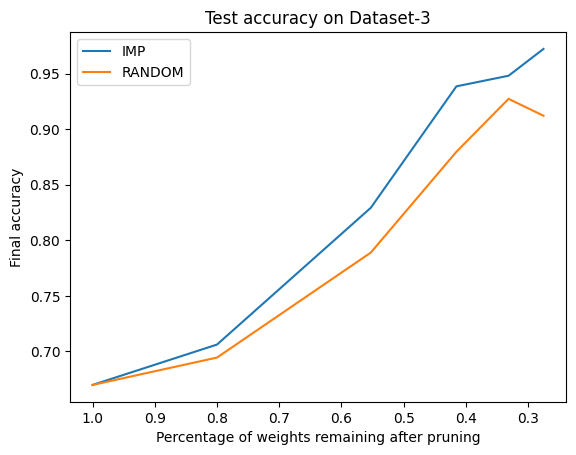

In [39]:
#plot the above three acc_dict on the same plot
#plot pr along x-axis
plt.figure()
plt.gca().invert_xaxis()
plt.plot(pr,[acc_dict[key]['test'][-1] for key in acc_dict.keys()],label= 'IMP')
# Reverse the x-axis


# plt.plot(pr,[acc_dictr[key]['test'][-1] for key in acc_dictr.keys()],label= 'one-shot-magnitude')
plt.plot(pr,[acc_dict[key]['test'][-1] for key in acc_dict.keys()][:1]+[acc_dictrp[key]['test'][-1] for key in acc_dictrp.keys()][:-1],label= 'RANDOM')


plt.legend()
plt.title('Test accuracy on Dataset-3')
plt.xlabel('Percentage of weights remaining after pruning')
plt.ylabel('Final accuracy')
